### Import library

In [1]:
library(siggenes)
library(plotly)
library(survival)
library(MASS)
library(survAUC)
library(coin)
library(samr)
library(HDclassif)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain intro

In [2]:
#view all dataframe
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

---
### Clinical data import

In [33]:
clinical1 <- read.csv("data.csv", header = TRUE)

clinical2 <- clinical1[, c("multifocality", "BRAF", "name")]
clinical2$name <- substr(clinical1$name, 1, 15)
clinical2$key <- row.names(clinical1)


# converting stage & focality

clinical2$PN <- as.character(clinical1$pathologyNstage)
clinical2$PN[clinical1$pathologyNstage %in% c("n1", "n1a", "n1b")] <- "n1"

clinical2$PT <- as.character(clinical1$pathologyTstage)
clinical2$PT[clinical1$pathologyTstage %in% c("t1", "t1a", "t1b")] <- "t1"
clinical2$PT[clinical1$pathologyTstage %in% c("t4", "t4a")] <- "t4"

clinical2$PT2 <- as.character(clinical2$PT)
clinical2$PT2[clinical2$PT %in% c("t1", "t2")] <- "t1 & t2"
clinical2$PT2[clinical2$PT %in% c("t3", "t4")] <- "t3 & t4"

clinical2$STAGE <- as.character(clinical1$pathologicstage)
clinical2$STAGE[clinical1$pathologicstage %in% c("stage iv", "stage iva", "stage ivc")] <- "stage iv"

clinical2$STAGE2 <- as.character(clinical2$STAGE)
clinical2$STAGE2[clinical2$STAGE %in% c("stage i", "stage ii")] <- "stage i & ii"
clinical2$STAGE2[clinical2$STAGE %in% c("stage iii", "stage iv")] <- "stage iii & iv"


clinical2$focality <- as.character(clinical1$multifocality)
clinical2$focality[clinical1$multifocality == "multifocal"] <- 1
clinical2$focality[clinical1$multifocality == "unifocal"] <- 0
clinical2$focality <- as.numeric(clinical2$focality)

---
### Loading miRNA

In [34]:
load("miRNA.RData")

#miRNA df name col 분리
name <- rownames(miRNA)
rownames(miRNA) <- NULL
miRNA <- cbind(name,miRNA)

#miRNA name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)
miRNA$name <- gsub("-", ".", miRNA$name)
miRNA$name <- substr(miRNA$name, 1, 15)

count.zero <- sapply(1:ncol(miRNA), function(i) sum(miRNA[, i] == 0)) 
selected.mirna <- names(miRNA)[which(count.zero/nrow(miRNA) < 0.1)]
del.mirna <- setdiff(names(miRNA), selected.mirna)

mirna <- miRNA[, selected.mirna]
#mirna[mirna == 0] <- NA
mirna$key <- row.names(mirna)

In [35]:
clinical3 <- merge(clinical2, mirna, by.x = "name", by.y = "name", all.x = TRUE)
head(clinical3, n=50L)

name,multifocality,BRAF,key.x,PN,PT,PT2,STAGE,STAGE2,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,⋯,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,key.y
,,NA,503,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
,,NA,504,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
,,NA,501,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,

In [36]:
clinical3 <- clinical3[1:ncol(clinical3)-1]

In [79]:
#focality na remove
clinical3 <- clinical3[!is.na(clinical3$focality), ]


#separate BRAF_p/focality

clinical_p <- clinical3[clinical3$BRAF %in% "1",]

clinical_p_uni <- clinical_p[clinical_p$focality %in% "0",]
clinical_p_multi <- clinical_p[clinical_p$focality %in% "1",]

---
### High-dimensional clustering

In [64]:
na_n <- rowSums(is.na(clinical3[, 11:ncol(clinical3)]))
na_p <- colSums(is.na(clinical3[, 11:ncol(clinical3)]))
sum(na_n)
sum(na_p)

[1] 338

[1] 338

In [65]:
#nomalizing
nor1 <- apply(clinical3[, 11:ncol(clinical3)], 2, min, na.rm = T)
nor2 <- apply(clinical3[, 11:ncol(clinical3)], 2, max, na.rm = T)

nor11 <- t(replicate(nrow(clinical3), nor1))
nor21 <- t(replicate(nrow(clinical3), nor2))

clinical4 <- (clinical3[, 11:ncol(clinical3)] - nor11)/(nor21 - nor11)

In [66]:
#na remove
clinical5 <- na.omit(clinical4)

Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 88 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 81 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 93 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 93 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 90 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 94 eigenvalue(s) converged, less than k = 100”Warning message in eigs_real_sym(A, nrow(A), k, which, sigma, opts, mattype = "sym_matrix", :
“only 86 eigenvalue(s) converg

HDDC: 
        model  K threshold        BIC       comment
1     ABKQKDK  2       0.2 328,400.08              
2   AKJBKQKDK  2       0.2 326,526.36              
3   AKJBKQKDK  3       0.2 325,170.99              
4    AKBKQKDK  3       0.2 323,521.20              
5    AKJBKQKD  2       0.2 322,268.36              
6     ABKQKDK  3       0.2 322,219.65              
7     AKBKQKD  2       0.2 322,182.08              
8      ABKQKD  2       0.2 322,047.06              
9     AKBKQKD  3       0.2 320,895.56              
10     ABKQKD  3       0.2 320,847.47              
11   AKBKQKDK  4       0.2 320,818.02              
12   AKBKQKDK  2       0.2 319,266.88              
13   AKJBQKDK  2       0.2 318,768.38              
14     ABQKDK  2       0.2 318,464.33              
15    AKBQKDK  2       0.2 318,462.83              
16   AKJBQKDK  3       0.2 306,920.05              
17    AKJBQKD  2       0.2 306,115.43              
18     AKBQKD  2       0.2 305,935.42              
19   

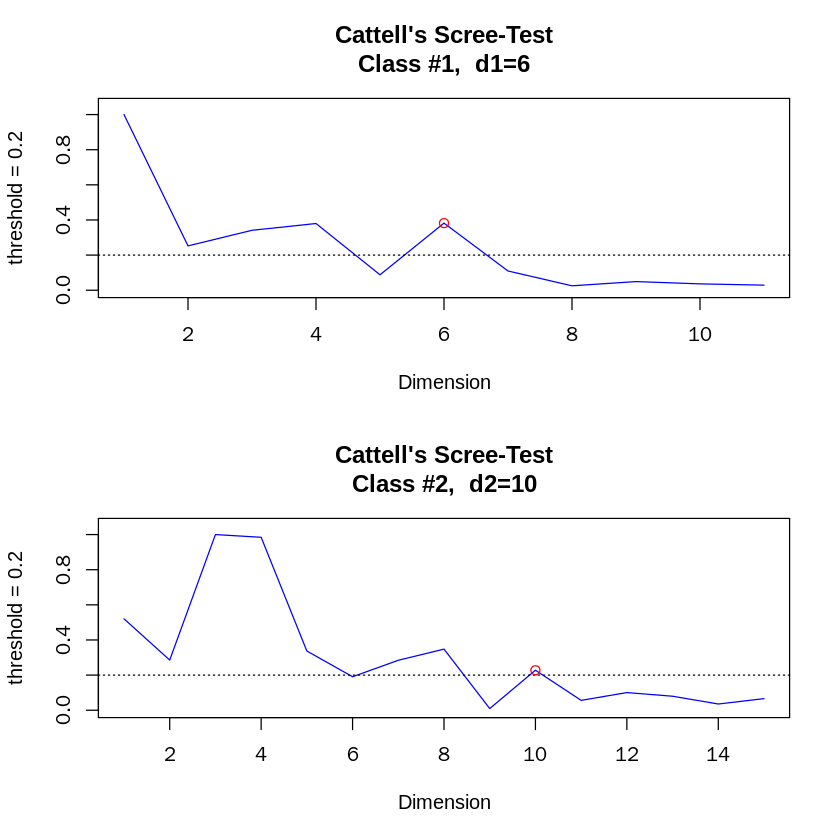

In [12]:
run <- readline("hddc (y/n): ")

if (run == "y"){
    clus1 <- hddc(clinical5, K = 1:10, model = "ALL", threshold = 0.2,
    criterion = "bic", com_dim = 5, itermax = 200, eps = 0.001,
    algo = "EM", d_select = "Cattell", init = "kmeans", init.vector,
    show = TRUE, mini.nb = c(5, 10), scaling = FALSE, min.individuals = 2,
    noise.ctrl = 1e-08, mc.cores = 1, nb.rep = 1, keepAllRes = TRUE,
    kmeans.control = list(), d_max = 100, d = "B")

    plot(clus1)
}

---
### SAM
* BRAF(+), multifocal target

In [103]:
target <- na.omit(clinical_p)

indi <- which(!is.na(target$focality))
set.seed(12345)
sam.out1 <- sam(t(target[indi, 11:ncol(target)]), target$focality[indi], B = 1000)

sam.out1

SAM Analysis for the Two-Class Unpaired Case Assuming Unequal Variances 
 
   Delta    p0   False Called    FDR
1    0.1 0.719 241.811    271 0.6415
2    0.2 0.719  94.613    126 0.5399
3    0.3 0.719  60.533     97 0.4487
4    0.4 0.719  19.798     45 0.3163
5    0.5 0.719   4.189     14 0.2151
6    0.6 0.719   0.853      7 0.0876
7    0.7 0.719   0.853      7 0.0876
8    0.8 0.719   0.575      6 0.0689
9    0.9 0.719       0      0      0
10   1.0 0.719       0      0      0

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


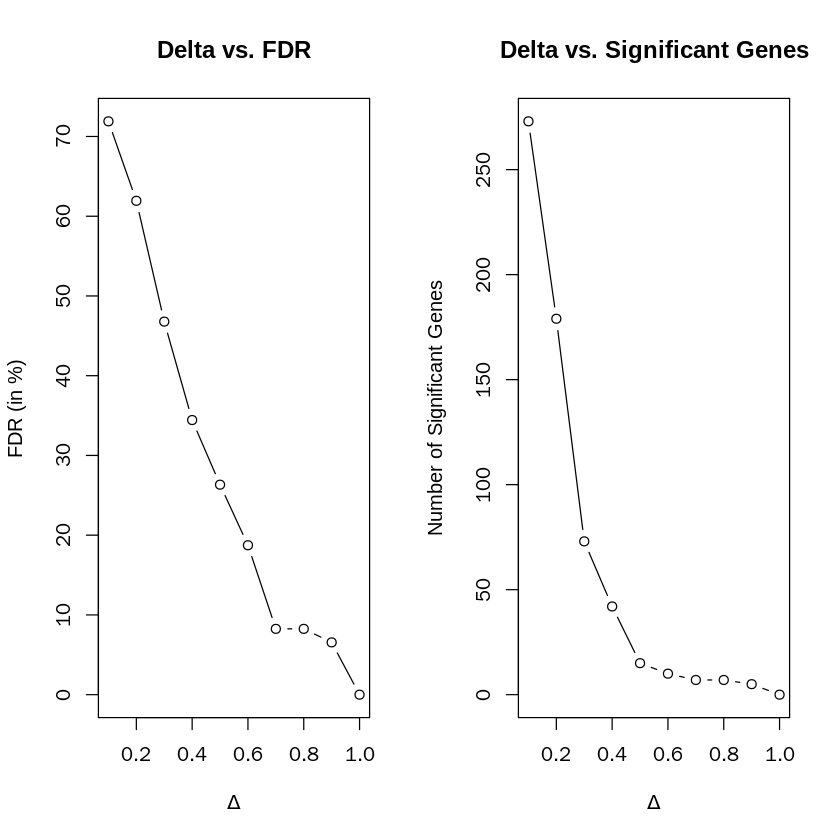

In [92]:
plot(sam.out1)

In [93]:
#data output
png("Delta vs DEG.png",width = 800, height = 800)

plot(sam.out1)

dev.off()

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


png 
  2

In [105]:
#delta finding
fin.Delta <- findDelta(sam.out1, fdr = 0.1)

The threshold seems to be at 
     Delta Called      FDR
5 0.589812     10 0.169815
6 0.589813      7 0.087609


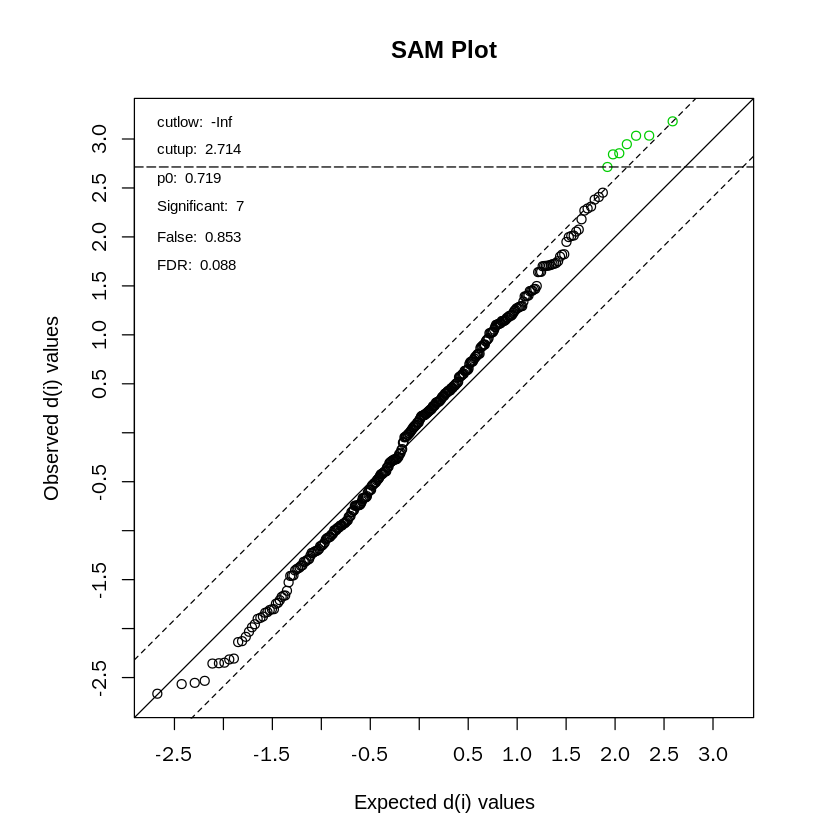

In [106]:
plot(sam.out1, fin.Delta[2, 1], pos.stats=1, main="SAM Plot")

In [107]:
gene.sig1 <- summary(sam.out1, fin.Delta[2, 1])@row.sig.genes

pval <- sam.out1@p.value
pi0 <- pi0.est(pval)$p0
qval <- qvalue.cal(pval, pi0)

pval.selected <- pval[names(pval) %in% names(gene.sig1)]
qval.selected <- qval[names(qval) %in% names(gene.sig1)]

pval.selected <- pval.selected[order(names(pval.selected))]
qval.selected <- qval.selected[order(names(qval.selected))]

write.csv(gene.sig1, "sig.genes1.csv")
save(gene.sig1, file = "gene.sig1.RData")

---
### Fold change

In [108]:
#head(clinical_p[indi, 11:ncol(clinical_p)-1])
#clinical_p$focality[indi]

tmp_p <- clinical_p[indi, 11:ncol(clinical_p)-1]

focal.mean1 <- apply(tmp_p[tmp_p$focality == 1, 2:ncol(tmp_p)], 2, function(x) mean(x, na.rm=TRUE))
focal.mean2 <- apply(tmp_p[tmp_p$focality == 0, 2:ncol(tmp_p)], 2, function(x) mean(x, na.rm=TRUE))
fold.change <- focal.mean1/focal.mean2

fold.change.selected <- fold.change[names(fold.change) %in% names(gene.sig1)]
fold.change.selected <- fold.change.selected[order(names(fold.change.selected))]

---

In [109]:
summary.ststs <- data.frame(gene = names(pval.selected),
                            p.value = as.numeric(pval.selected),
                            q.value = as.numeric(qval.selected),
                            fold.change = as.numeric(fold.change.selected))

write.csv(summary.ststs, "summary.ststs.csv", row.names = FALSE)

---
### clinical data output

In [99]:
clin <- clinical_p[, c(1:10)]
clin1 <- clinical_p[, names(gene.sig1)]
fin.clin <- cbind(clin, clin1)
write.csv(fin.clin, file = "clinical.final.csv")

clin <- clinical_n[, c(1:10)]
clin1 <- clinical_n[, names(gene.sig1)]
fin.clin <- cbind(clin, clin1)
write.csv(fin.clin, file = "clinical.final.csv")

---
### plot

In [27]:
clinical01 <- clinical_p[indi,]
clinical02 <- clinical01[clinical01$focality == 1, names(gene.sig1)]
clinical03 <- clinical01[clinical01$focality == 0, names(gene.sig1)]

diff <- apply(clinical02, 2, median, na.rm = TRUE) - apply(clinical03, 2, median, na.rm = TRUE)
sum(diff < 0)
sum(diff >= 0)

write.csv(diff, "sig.genes.csv")

[1] 0

[1] 5

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


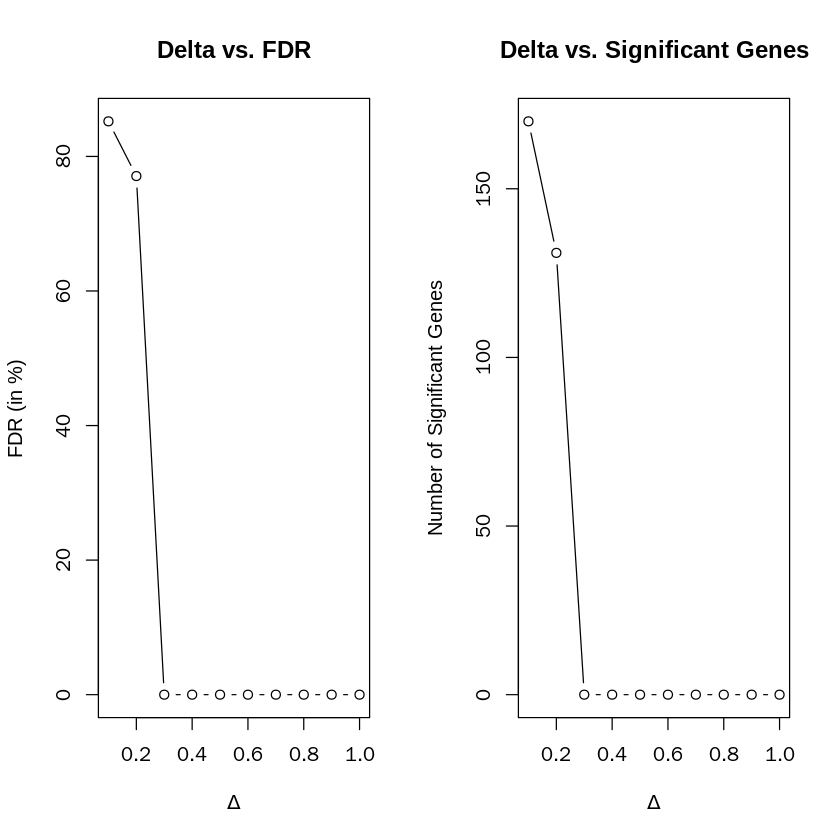

In [28]:
#SAM  - clunical_n
indi <- which(!is.na(clinical_n$focality))
set.seed(12345)
sam.out1 <- sam(t(clinical_n[indi, 11:ncol(clinical_n)]), clinical_n$focality[indi], B = 1000)
plot(sam.out1)

In [29]:
sam.out1

SAM Analysis for the Two-Class Unpaired Case Assuming Unequal Variances 
 
   Delta   p0   False Called   FDR
1    0.1 0.95 152.548    170 0.852
2    0.2 0.95 106.332    131 0.771
3    0.3 0.95       0      0     0
4    0.4 0.95       0      0     0
5    0.5 0.95       0      0     0
6    0.6 0.95       0      0     0
7    0.7 0.95       0      0     0
8    0.8 0.95       0      0     0
9    0.9 0.95       0      0     0
10   1.0 0.95       0      0     0

The threshold seems to be at 
     Delta Called      FDR
5 0.230415    123 0.746196
6 0.230416      0 0.000000


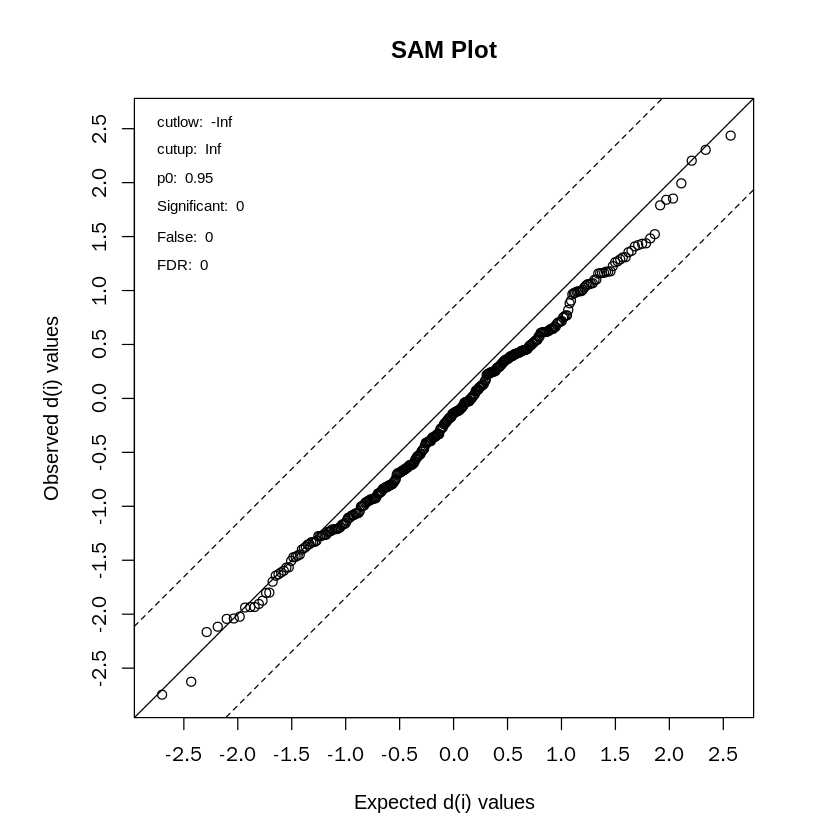

In [30]:
findDelta(sam.out1, fdr = 0.0825)
plot(sam.out1, fin.Delta[2,1], pos.stats=1, main="SAM Plot")
gene.sig1 <- summary(sam.out1, 1.098185)@row.sig.genes

write.csv(gene.sig1, "sig.genes.csv")

In [31]:
###########plot
clinical01 <- clinical_p[indi,]
clinical02 <- clinical01[clinical01$focality == 1, names(gene.sig1)]
clinical03 <- clinical01[clinical01$focality == 0, names(gene.sig1)]

diff <- apply(clinical02, 2, median, na.rm = TRUE) - apply(clinical03, 2, median, na.rm = TRUE)
sum(diff < 0)
sum(diff >= 0)

write.csv(diff, "sig.genes.csv")

[1] 0

[1] 0